In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
import seaborn as sns
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

Welcome to JupyROOT 6.26/00


In [2]:
sigma_df=pd.read_csv('sigma.csv',index_col=0)
sigma_alt_df=pd.read_csv('../realdeal/sigma.csv',index_col=0)
sigma_chi2_df=pd.read_csv('../realdeal/sigma_chi2.csv',index_col=0)
diagnostics_df=pd.read_csv('diagnostics.csv',index_col=0)

In [3]:
rel_err=np.abs(np.array(diagnostics_df.loc[['mcse']])[0]/np.array(diagnostics_df.loc[['sigma_median']])[0])
np.where(rel_err>=0.05)

(array([  0,  12, 111, 112, 124]),)

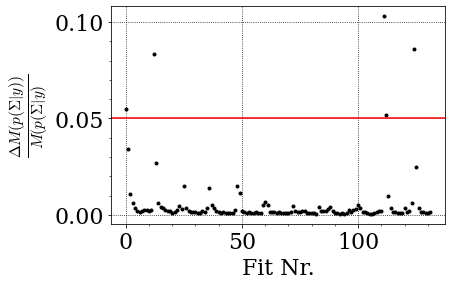

In [4]:
fig, ax = plt.subplots()
ax.plot(np.arange(132),np.abs(np.array(diagnostics_df.loc[['mcse']])[0]/np.array(diagnostics_df.loc[['sigma_median']])[0]),'.')
ax.set_xlabel('Fit Nr.')
ax.set_ylabel('$\\frac{\Delta M(p(\Sigma|y))}{M(p(\Sigma|y)}$')
#ax.set_ylim([0,0.5])
ax.axhline(y=0.05,color='red')
plt.show()
fig.savefig('./plots/mcse_hist.pdf',format='pdf',bbox_inches='tight',dpi=1000)

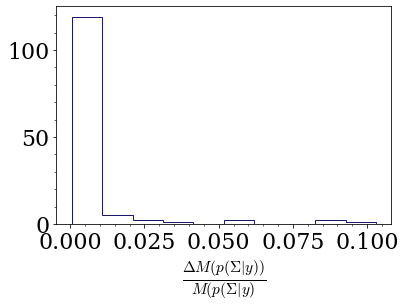

In [5]:
plt.hist(np.abs(np.array(diagnostics_df.loc[['mcse']])[0]/np.array(diagnostics_df.loc[['sigma_median']])[0]),histtype='step',color='midnightblue')
plt.xlabel('$\\frac{\Delta M(p(\Sigma|y))}{M(p(\Sigma|y)}$')
plt.grid(False)
plt.savefig('./plots/mcse_hist.pdf',bbox_inches='tight')
plt.show()

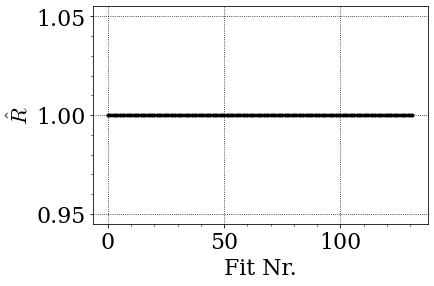

In [6]:
fig, ax = plt.subplots()
ax.plot(np.arange(132),np.array(diagnostics_df.loc[['rhat']])[0],'.')
ax.set_xlabel('Fit Nr.')
ax.set_ylabel('$\hat{R}$')
plt.show()
fig.savefig('rhat.pdf',format='pdf',dpi=1000)

In [9]:
fig,ax = plt.subplots(4,3,sharex='col',sharey='row',dpi=1000,figsize=(10,7))
plt.subplots_adjust(wspace=0, hspace=0)
fig.delaxes(ax[3,2]) #The indexing is zero-based here
ax[2,2].get_xaxis().set_visible(True)
ax[2,2].xaxis.set_tick_params(which='both', labelbottom=True)
farahs_data=pd.read_csv('../realdeal/Sigma_eta_datapoints_final_newsyserrorcalc.txt',sep=' ',header=None)
farahs_data.columns=['W','egamma','costheta','sigma','stat_error','sys_error','idk']
counter=0
for i in range(4):
    for j in range(3):
        if(j==0 and i==0):
            ax[i][j].set_ylabel('$\Sigma$')
        if(j>0 and (i==2 or i==3)):
            ax[i][j].set_xlabel('$\cos\\theta_{\eta}^{\mathrm{CMS}}$')
        ax[i][j].set_xlim([-1.2,1.2])
        ax[i][j].set_ylim([-1.5,1.5])
        x=[-1+2/12/2+(i)*2/12 for i in range(12)]
        if(counter<11):
            #sigma (point estimate) from event yield asymmetries
            ax[i][j].errorbar(x=x,
                              y=[sigma_chi2_df[f"ebin{counter:02d}costbin{j:02d}"]['sigma']for j in range(12)],
                              yerr=[sigma_chi2_df[f"ebin{counter:02d}costbin{j:02d}"]['error'] for j in range(12)],
                              fmt='s',markersize=4.,color='peachpuff',label='$\chi^2 - fit$')
            #sigma (point estimate) from event based fit
            ax[i][j].errorbar(x=x,y=farahs_data['sigma'][counter*12:counter*12+12],
                              yerr=farahs_data['stat_error'][counter*12:counter*12+12],
                              fmt='v',markersize=4.,color='darkorange',label='Event based fit')
            #plot sigma posterior obtained from event based fit
            vp=ax[i][j].violinplot([sigma_df[f"ebin{counter:02d}costbin{j:02d}"] for j in range(12)],
                                   x,
                                showmeans=False, showextrema=False, showmedians=False,widths=0.3)
            #sigma posterior obtained from event yield asymmetries
            vpalt=ax[i][j].violinplot([sigma_alt_df[f"ebin{counter:02d}costbin{j:02d}"] for j in range(12)],
                                      x,
                                 showmeans=False, showextrema=False, showmedians=False,widths=0.3)
            ax[i][j].text(0,-1,f'${1130+counter*60}$ MeV $\leq E_\gamma < {1130+(counter+1)*60}$ MeV',
                          fontsize=14,ha='center',va='center')
            #cosmetics
            for b in vp['bodies']:
                # get the center
                m = np.mean(b.get_paths()[0].vertices[:, 0])
                # modify the paths to not go further right than the center
                b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
                b.set_alpha(.5)
                b.set_color('navy')
            for b in vpalt['bodies']:
                # get the center
                m = np.mean(b.get_paths()[0].vertices[:, 0])
                # modify the paths to not go further right than the center
                b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
                b.set_alpha(.2)
                b.set_color('navy')    
        counter+=1
lines,labels = ax[0][0].get_legend_handles_labels() 
patch1 = mpatches.Patch(color='navy', label='bayesian fit (event based)',alpha=.5)
patch = mpatches.Patch(color='navy', label='bayesian fit (event yield asymmetries)',alpha=.1)

lines.append(patch)
lines.append(patch1)

plt.legend(handles=lines,bbox_to_anchor=(1.4,-0.6))        
plt.show()
fig.savefig(f'./sigma_eta_alt.pdf',format='pdf',bbox_inches='tight',dpi=1000)

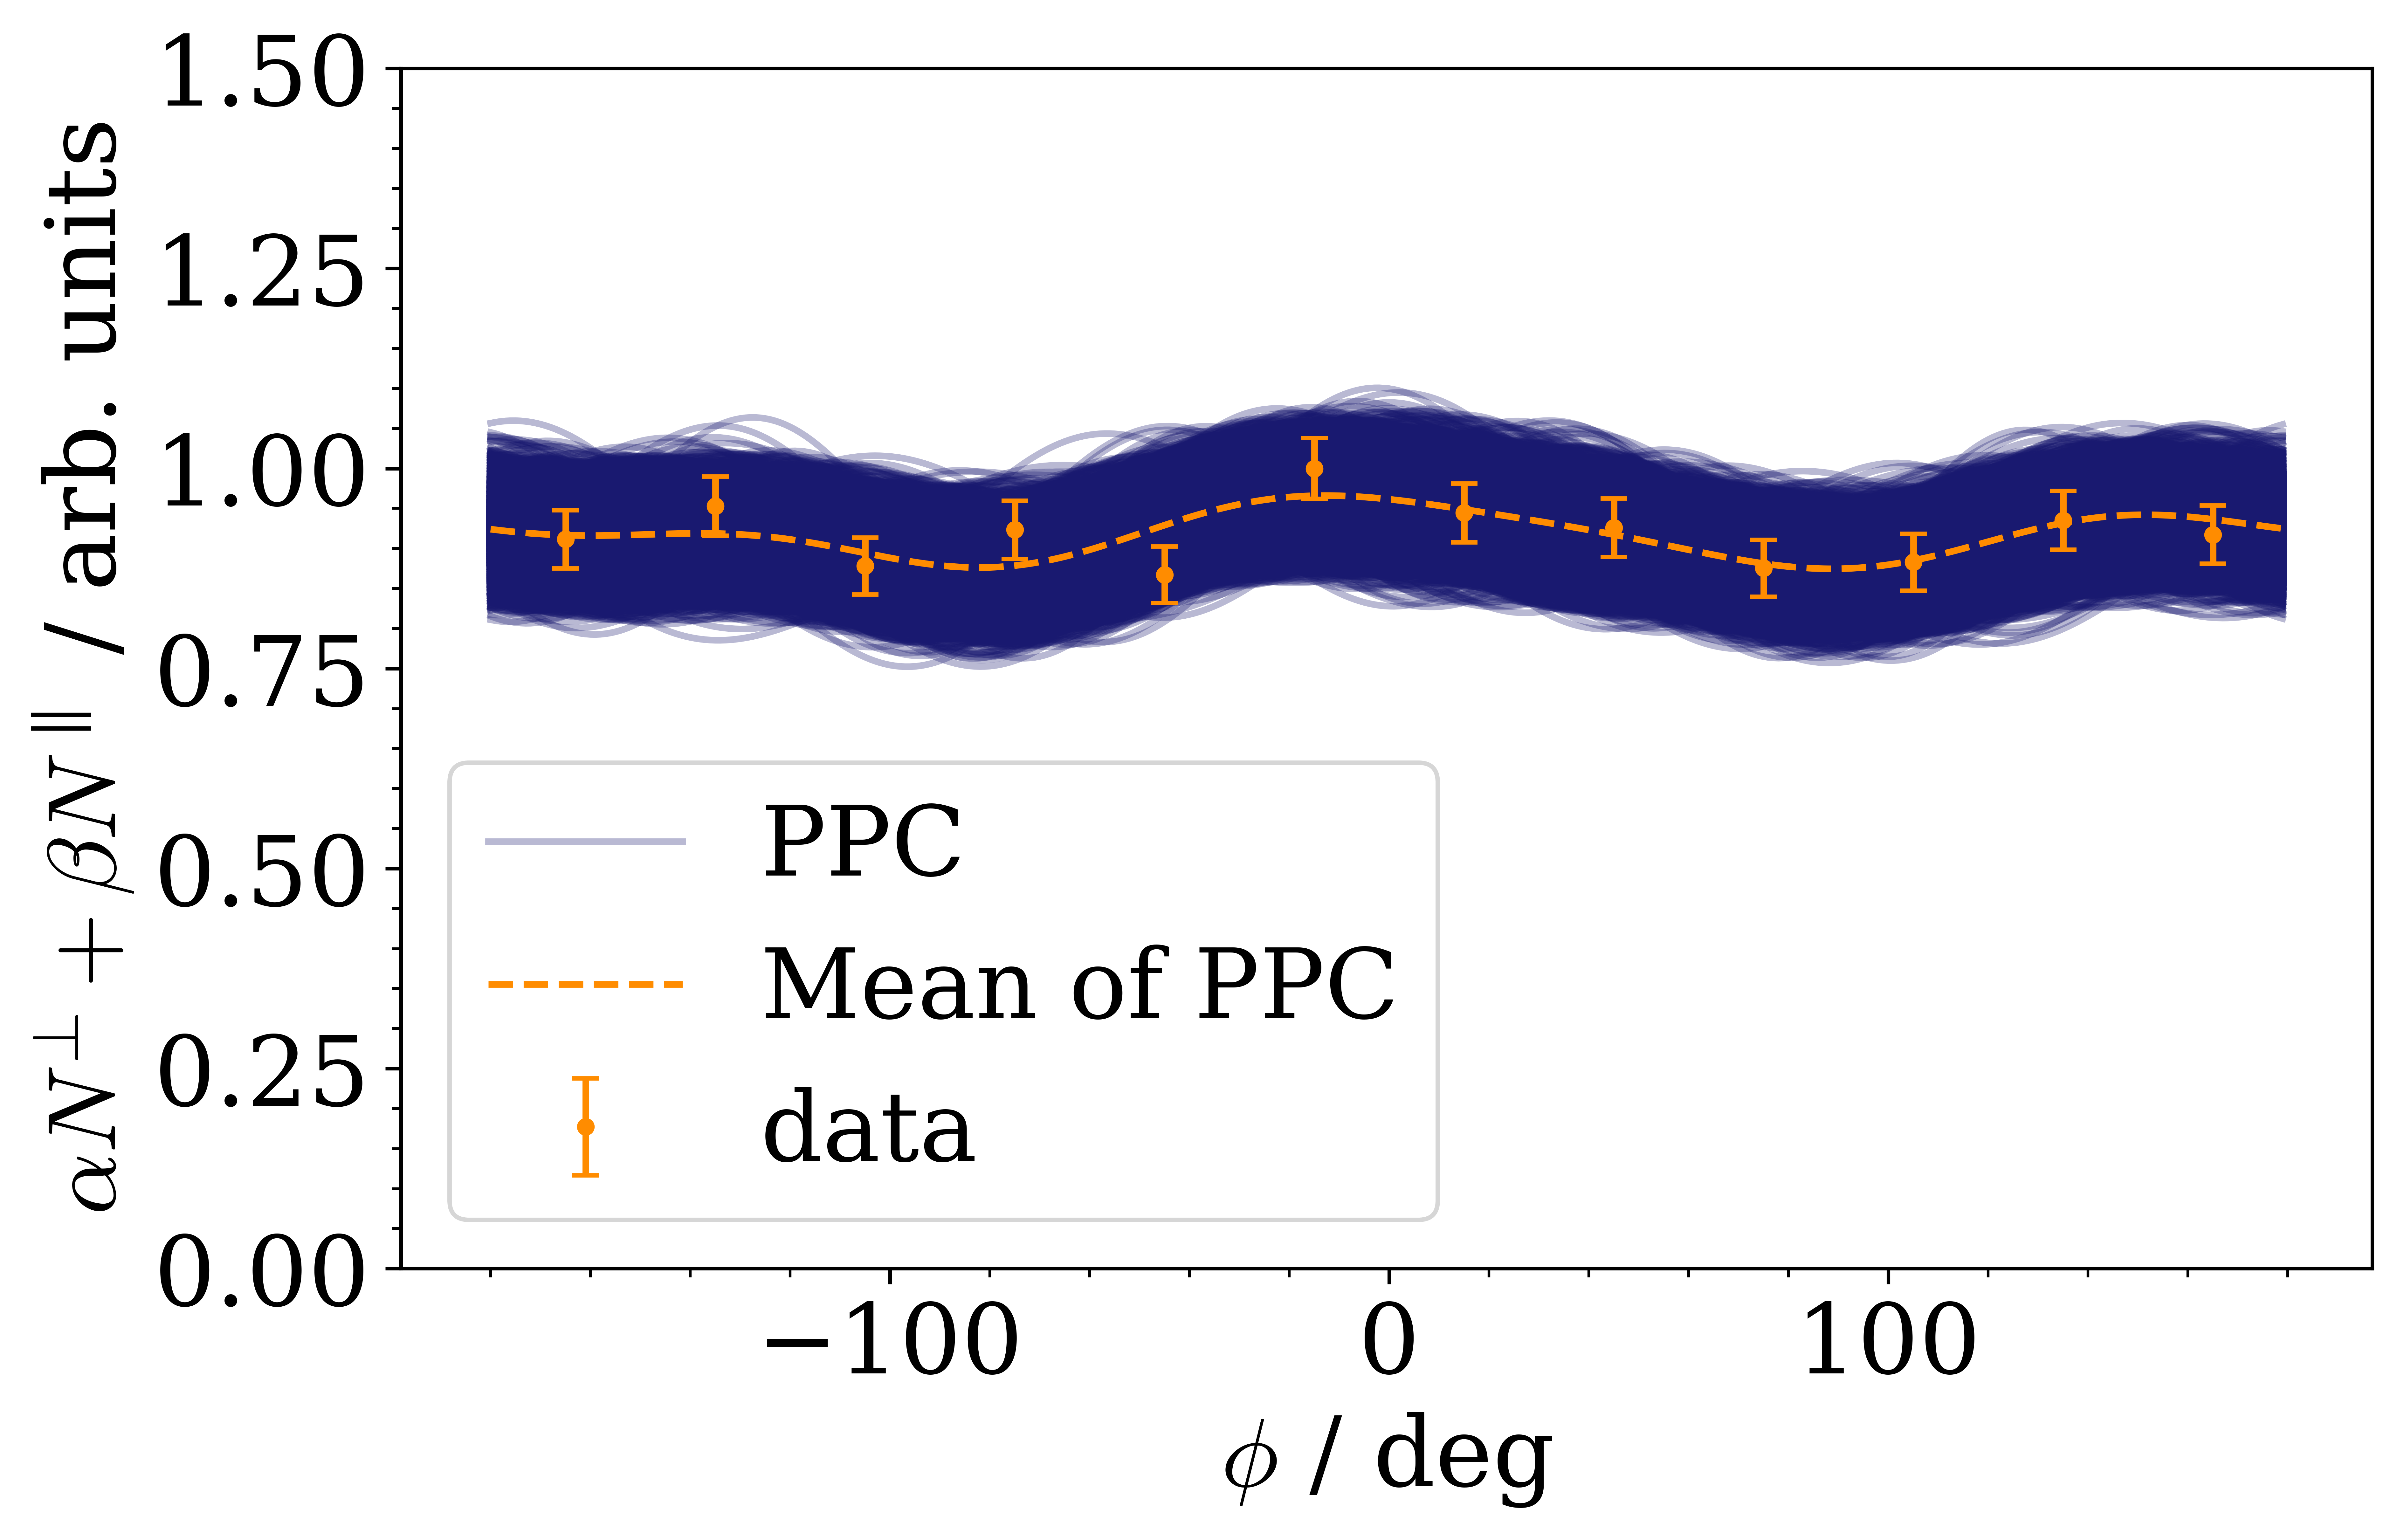

Warning in <TROOT::Append>: Replacing existing TH1: p45 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: m45 (Potential memory leak).


In [13]:
#read data
i=3 # define which bin to use
j=6
samples=pd.read_csv(f'samples_ebin{i:02d}costbin{j:02d}.txt',index_col=0)
summary=pd.read_csv(f'summary_ebin{i:02d}costbin{j:02d}.txt',index_col=0)

df=pd.read_csv(f"ebin{i:02d}/ebin{i:02d}costbin{j:02d}.txt",sep="\t")
df.columns=['pol','phi','weight']
#select only prmpt events
p45=df.loc[(df['weight']==1)&(df['pol']>0)].reset_index(drop=True)
m45=df.loc[(df['weight']==1)&(df['pol']<0)].reset_index(drop=True)
hp45=r.TH1F("p45","p45",12,-180,180)
hm45=r.TH1F("m45","m45",12,-180,180)
#histogram them
for i in p45['phi'].values:
    hp45.Fill(i)
for i in m45['phi'].values:
    hm45.Fill(i)
#normalize    
norm_p = 1./hp45.Integral()
norm_m = 1./hm45.Integral()
hp45.Scale(norm_p)
hm45.Scale(norm_m)
#build polarization weighted sum
pol_p45=np.abs(np.mean(p45['pol']))
pol_m45=np.abs(np.mean(m45['pol']))
hp45.Add(hp45,hm45,pol_m45/(pol_p45+pol_m45),pol_p45/(pol_m45+pol_p45))
hp45.Scale(1./hp45.GetMaximum())
#write values of histo to numpy array
asym=[]
asym_err=[]
phi=[]
for i in range(hp45.GetNbinsX()):
    asym.append(hp45.GetBinContent(i+1))
    asym_err.append(hp45.GetBinError(i+1))
    phi.append(hp45.GetBinCenter(i+1))
asym=np.array(asym)
asym_err=np.array(asym_err)
phi=np.array(phi)
xx=np.arange(-180,180)

#plot results
fig, ax = plt.subplots(figsize=(8,5),dpi=1000)
ax.errorbar(x=phi,y=asym,yerr=asym_err,fmt='.',color='darkorange',zorder=3,label='data')
#get ALL values of fourier coeff
eff_list=[]
for i in range(20000):
    #get mean values of fourier coeff
    tmp_a=[samples[f'a[{j+1}]'][i] for j in range(4)]
    tmp_b=[samples[f'b[{j+1}]'][i] for j in range(4)]
    #put them in efficiency function
    def tmp_eff(x,c):
        val=1 # a0=0,b0=1
        for i in range(4):
            val+=tmp_a[i]*np.sin((i+1)*x*np.pi/180)+tmp_b[i]*np.cos((i+1)*x*np.pi/180)
        return c*val 
    popt,pcov = curve_fit(tmp_eff,xdata=phi,ydata=asym,p0=1,sigma=asym_err)
    eff_list.append(tmp_eff(xx,popt))
    #ax.plot(xx,eff(xx,popt),color='midnightblue',alpha=0.5)
for i in range(20000):
    if(i==0):
        ax.plot(xx,eff_list[i],color='midnightblue',alpha=0.3,label='PPC')
    else:
        ax.plot(xx,eff_list[i],color='midnightblue',alpha=0.3)
#get mean values of fourier coeff
a=[summary['Mean'][f'a[{i+1}]'] for i in range(4)]
b=[summary['Mean'][f'b[{i+1}]'] for i in range(4)]
#put them in efficiency function
def eff(x,c):
    val=1 # a0=0,b0=1
    for i in range(4):
        val+=a[i]*np.sin((i+1)*x*np.pi/180)+b[i]*np.cos((i+1)*x*np.pi/180)
    return c*val 
popt,pcov = curve_fit(eff,xdata=phi,ydata=asym,p0=1,sigma=asym_err)
ax.plot(xx,eff(xx,popt),color='darkorange',ls='--',label='Mean of PPC')

    
    

ax.set_ylim([0,1.5])
ax.set_xlabel("$\phi$ / deg")
ax.set_ylabel(r"$\alpha N^{\bot} + \beta N^{\parallel} $ / arb. units")
ax.grid(False)
plt.legend()
plt.show()
fig.savefig('./plots/eff_PPC.pdf',format='pdf',dpi=1000,bbox_inches='tight')